In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
from file_cache import *
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


2020-07-18 11:14:41,415 util_log.py[153] INFO Start the program at:amax7, 127.0.1.1, with:Load module


File_cache: Adjust notebook work fold to:/share/felix/pj/thyroid_seg/


In [3]:
df = pd.read_csv('/home/felix/pj/thyroid_seg/input/TNSCUI2020_train/train.csv')
print(df.shape)
df.head()

(3644, 2)


,ID,CATE
0,5189.PNG,0
1,2090.PNG,1
2,5156.PNG,0
3,8303.PNG,1
4,9650.PNG,1


In [4]:
df.CATE.value_counts()

1    2003
0    1641
Name: CATE, dtype: int64

In [5]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [6]:

from file_cache import *

img_file_list = glob('/home/felix/pj/thyroid_seg/input/TNSCUI2020_train/image/*.PNG', recursive=True)

df = pd.DataFrame({'img_file':img_file_list})

df['label_path'] = df.img_file.apply(lambda val: val.replace('image', 'mask'))
df['sn'] = df.img_file.apply(lambda val: os.path.basename(val).split('.')[0]  ).astype(int)
df = df.sort_values('sn')

df['valid'] = df.sn%5 >=4
df.head()

df['size1'] = df.label_path.apply(lambda val: cv2.imread(val).shape[0])
df['size2'] = df.label_path.apply(lambda val: cv2.imread(val).shape[1])
df.sort_values('size1')

codes = list(range(2))
print('codes', list(codes) )


src = (SegmentationItemList.from_df(df, path='/', cols='img_file' )
       .split_from_df(col='valid')
       .label_from_df(cols='label_path', classes=codes)
      )

2020-07-18 11:14:42,817 utils.py[129] INFO Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-07-18 11:14:42,818 utils.py[141] INFO NumExpr defaulting to 8 threads.


codes [0, 1]


In [7]:
np.unique(cv2.imread(df.iloc[0,1]), return_counts=True)

(array([0, 1], dtype=uint8), array([866472,   6438]))

In [8]:
# for file in df.label_path:
#     #print(file)
#     img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
#     #print(img.shape)
#     cv2.imwrite(file, img/max(1, img.max()) )

## Datasets

In [9]:
size =224
bs = 4
print('size, bs', size, bs)

size, bs 224 4


In [10]:
 
    
print(len(src.train), len(src.valid), codes)

#get_transforms()
data = (src.transform(None, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

2942 702 [0, 1]


In [11]:
# tmp = df.groupby(['p_id', 'valid'], as_index=False).label_path.count()
# tmp.pivot_table(index='p_id', columns='valid', values='label_path').sort_values(0)

In [12]:
for a, b in data.dl(DatasetType.Train):
    break
    
a.shape

torch.Size([4, 3, 224, 224])

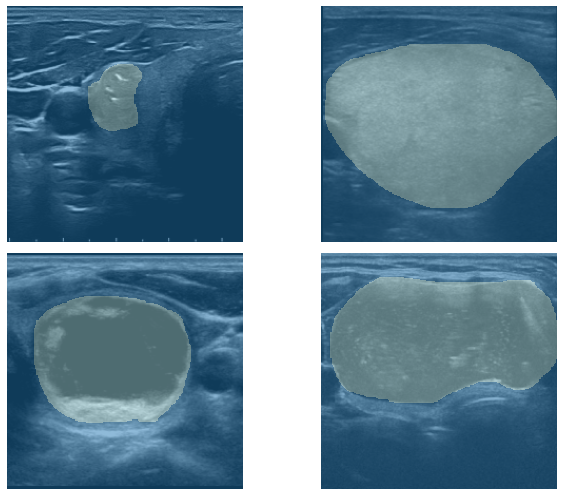

In [13]:
data.show_batch(8, figsize=(10, 7))

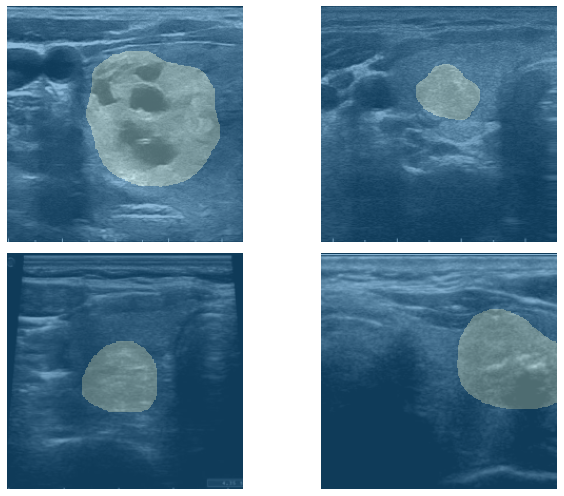

In [14]:
data.show_batch(4, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [15]:
name2id = {v:k for k,v in enumerate(codes)}
#void_code = name2id['Void']

# def acc_camvid(input, target):
#     target = target.squeeze(1)
#     mask = target != void_code
#     return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [16]:
wd = 1e-2


In [17]:
print('abc', data.c)

abc 2


In [18]:
#多类别的Dice Metrics

from brain.metrics import * 

from functools import partial
def dice_fn(cls_id):
    fn = partial(dice_multiply, cls_id=cls_id) 
    fn.__name__ = f'dice_{cls_id}'
    return fn
 

metrics = [ dice_fn(i) for i in codes ] #, accuracy,
print('len=', len(metrics))
#import ipdb
# ipdb.set_trace()
learn = unet_learner(data, models.resnet50, metrics=metrics , wd=wd)

# for sn, child in enumerate(learn.model.children()):
#     print(sn, '===', child)

len= 2


In [19]:
os.path.abspath('./output/model')

'/share/felix/pj/thyroid_seg/output/model'

In [20]:
torch.rand(3,64, 64).cuda().shape

torch.Size([3, 64, 64])

In [21]:

learn.model_dir=os.path.abspath('./output/model')
os.makedirs(learn.model_dir, exist_ok=True)
learn.lr_find()

epoch,train_loss,valid_loss,dice_0,dice_1,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


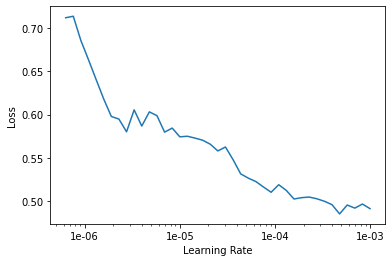

In [22]:
learn.recorder.plot()

In [23]:
lr = 1e-4
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,time
0,0.156558,0.147712,0.962518,0.595287,05:56
1,0.158939,0.142475,0.962523,0.618401,06:02
2,0.126684,0.134019,0.966764,0.697678,05:59
3,0.100295,0.109321,0.974052,0.716963,05:58
4,0.054568,0.092433,0.977645,0.784429,05:58


In [24]:
lr = 1e-4
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,time
0,0.037818,0.109927,0.978152,0.778552,05:59
1,0.041784,0.099803,0.976924,0.779511,05:58
2,0.039148,0.116794,0.977575,0.766818,05:58
3,0.037498,0.129917,0.974080,0.744067,05:59
4,0.022519,0.119321,0.978609,0.779577,05:58


In [25]:
lr = 1e-4
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,time
0,0.024072,0.121507,0.978824,0.798085,05:59
1,0.017825,0.136788,0.978864,0.781158,05:59
2,0.015272,0.155351,0.979444,0.798281,05:59
3,0.015368,0.160584,0.978817,0.782674,05:59
4,0.017661,0.150354,0.978623,0.786254,05:59
5,0.020690,0.156233,0.975644,0.727513,05:59
6,0.021196,0.133917,0.977090,0.739425,05:59
7,0.018027,0.143531,0.977975,0.763392,06:00
8,0.019575,0.140128,0.978135,0.770744,05:59
9,0.013316,0.137166,0.978696,0.785165,06:00


In [26]:
lr = 1e-4
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,time
0,0.010809,0.144766,0.979094,0.785188,05:58
1,0.009738,0.145525,0.979046,0.784111,05:59
2,0.011146,0.137620,0.979122,0.796358,06:00
3,0.009852,0.208354,0.978638,0.785010,05:59
4,0.010559,0.261574,0.978160,0.747657,05:59
5,0.015782,0.176317,0.976691,0.742866,05:59
6,0.013097,0.188080,0.975767,0.738969,05:59
7,0.011699,0.191320,0.977654,0.754105,05:59
8,0.013542,0.138904,0.976417,0.769657,05:59
9,0.009401,0.188763,0.978251,0.775335,06:00


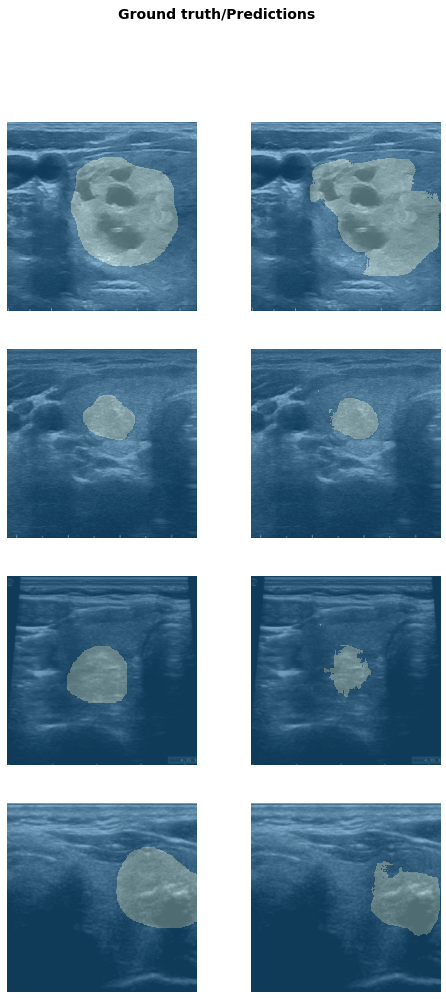

In [27]:
learn.show_results(DatasetType.Valid, rows=40)
